In [1]:
!pip install tensorboardcolab

In [0]:
import keras
import csv
import os
import itertools
import numpy as np
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from google.colab import drive, files
from tensorboardcolab import *
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TRAIN_DIR = r'/content/drive/My Drive/domain_adaptation_images/amazon/images'
VAL_DIR =  r'/content/drive/My Drive/domain_adaptation_images/dslr/images'
TEST_DIR =  r'/content/drive/My Drive/domain_adaptation_images/webcam/images'

In [0]:
img_width, img_height = 520, 520

In [0]:
batch_size = 32
epoch = 10
drop_prob = 0.5
out_class = 31

In [0]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [0]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 2817 images belonging to 31 classes.


In [10]:
val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 498 images belonging to 31 classes.


In [11]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 795 images belonging to 31 classes.


In [12]:
input_ = Input(shape=(img_width, img_height, 3))
transfer_model = InceptionV3(input_tensor = input_, weights = 'imagenet', include_top = False)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [13]:
x = transfer_model.output

x = MaxPooling2D()(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(inputs = transfer_model.input, outputs = out)

In [0]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [0]:
for layer in transfer_model.layers:
    layer.trainable = False

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 520, 520, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 259, 259, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 259, 259, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 259, 259, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

Wait for 8 seconds...
TensorBoard link:
https://974e2bae.ngrok.io


In [0]:
checkpointer = ModelCheckpoint(filepath='checkpoint_DA.h5', save_best_only=True)

In [0]:
callback_list = [tensorboard, checkpointer]

In [22]:
model.fit_generator(train_generator, steps_per_epoch = int(2817/batch_size), epochs = epoch, shuffle = True, 
                   validation_data = val_generator, validation_steps = int(498/batch_size), callbacks = callback_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
88/88 [==============================] - 979s 11s/step - loss: 3.8992 - acc: 0.3026 - val_loss: 2.4934 - val_acc: 0.4437
Epoch 2/10
88/88 [==============================] - 172s 2s/step - loss: 2.3823 - acc: 0.5452 - val_loss: 1.8559 - val_acc: 0.5751
Epoch 3/10
88/88 [==============================] - 176s 2s/step - loss: 1.9208 - acc: 0.6420 - val_loss: 1.5770 - val_acc: 0.6245
Epoch 4/10
88/88 [==============================] - 178s 2s/step - loss: 1.3180 - acc: 0.6904 - val_loss: 1.4038 - val_acc: 0.5987
Epoch 5/10
88/88 [==============================] - 177s 2s/step - loss: 1.0452 - acc: 0.7487 - val_loss: 1.2813 - val_acc: 0.6803
Epoch 6/10
88/88 [==============================] - 180s 2s/step - loss: 1.0187 - acc: 0.7600 - val_loss: 1.1369 - val_acc: 0.7060
Epoch 7/10
88/88 [==============================] - 176s 2s/step - loss: 0.8951 - acc: 0.7909 - val_loss: 1.1752 - val_acc: 0.6845
Epoch 8/10
88/88 [================

In [0]:
Y_pred = model.predict_generator(test_generator, int(795/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [0]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(795/batch_size+1))

In [59]:
test_loss

1.5337694049631274

In [60]:
test_accuracy

0.6314465400557848

In [0]:
model_check = load_model('checkpoint_DA.h5')

In [0]:
test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [64]:
test_check_loss

1.4074894671170217

In [65]:
test_check_acc

0.6503144645840867

In [0]:
target_names = ['Back pack', 'Bike', 'Bike Helmet', 'Bookcase', 'Bottle', 'Calculator', 'Desk chair', 'Desk lamp', 'Desktop computer', 'File cabinet', 
               'Headphones', 'Keyboard', 'Laptop', 'Letter tray', 'Mobile phone', 'Monitor', 'Mouse', 'Mug', 'Paper Notebook', 'Pen', 'Phone', 'Printer', 'Projector', 
               'Punchers', 'Ring binder', 'Ruler', 'Scissors', 'Speaker', 'Stapler', 'Tape dispenser', 'Trash can']

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [0]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[0 2 0 0 0 4 2 0 0 0 0 2 5 0 0 1 1 1 3 1 0 1 0 0 0 1 1 0 0 4 0]
 [0 0 1 0 0 1 2 0 1 0 0 0 2 0 1 1 1 2 2 1 0 0 0 0 1 1 0 2 0 2 0]
 [0 2 1 0 1 3 2 0 0 2 1 0 2 0 0 0 2 1 0 2 0 0 0 0 1 0 0 1 0 7 0]
 [0 0 1 0 0 3 1 0 0 0 1 0 0 0 0 0 0 1 2 0 0 0 1 0 0 0 0 0 0 2 0]
 [1 1 0 1 0 1 2 0 1 0 1 0 1 1 0 0 0 0 2 1 0 0 0 0 0 0 0 1 0 2 0]
 [0 0 0 0 0 2 1 1 2 1 2 0 2 1 0 0 1 1 4 3 0 1 1 1 0 0 0 3 1 3 0]
 [2 0 1 0 0 1 2 0 0 3 0 0 6 2 0 1 1 0 5 2 2 1 2 0 1 2 1 1 0 2 2]
 [0 1 0 1 0 1 0 0 2 0 0 0 0 0 0 0 1 0 2 2 0 1 0 0 0 1 1 2 0 3 0]
 [0 1 0 1 0 2 1 0 1 1 0 0 2 0 0 2 1 1 1 1 0 0 1 0 0 0 1 1 0 3 0]
 [0 0 0 0 0 1 0 0 2 0 1 2 1 1 0 1 0 2 0 1 0 0 1 0 0 0 2 0 0 4 0]
 [0 1 2 0 0 1 0 0 2 1 0 0 0 0 0 2 0 3 5 1 0 0 1 2 1 0 1 1 0 3 0]
 [1 0 0 0 1 3 1 2 0 1 1 0 3 1 0 1 0 2 1 3 0 0 1 0 0 1 1 0 0 3 0]
 [0 1 0 0 0 4 1 2 1 1 3 0 0 1 0 1 1 0 1 1 1 1 0 2 0 2 2 2 0 2 0]
 [0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 2 2 2 1 2 0 0 0 0 0 0 0 1 0 2 0]
 [0 0 0 0 1 1 1 0 0 2 3 0 0 2 0 1 2 1 2 1 0 1 1 0 1 1 1 4 0 4 0]
 [0 1 2 

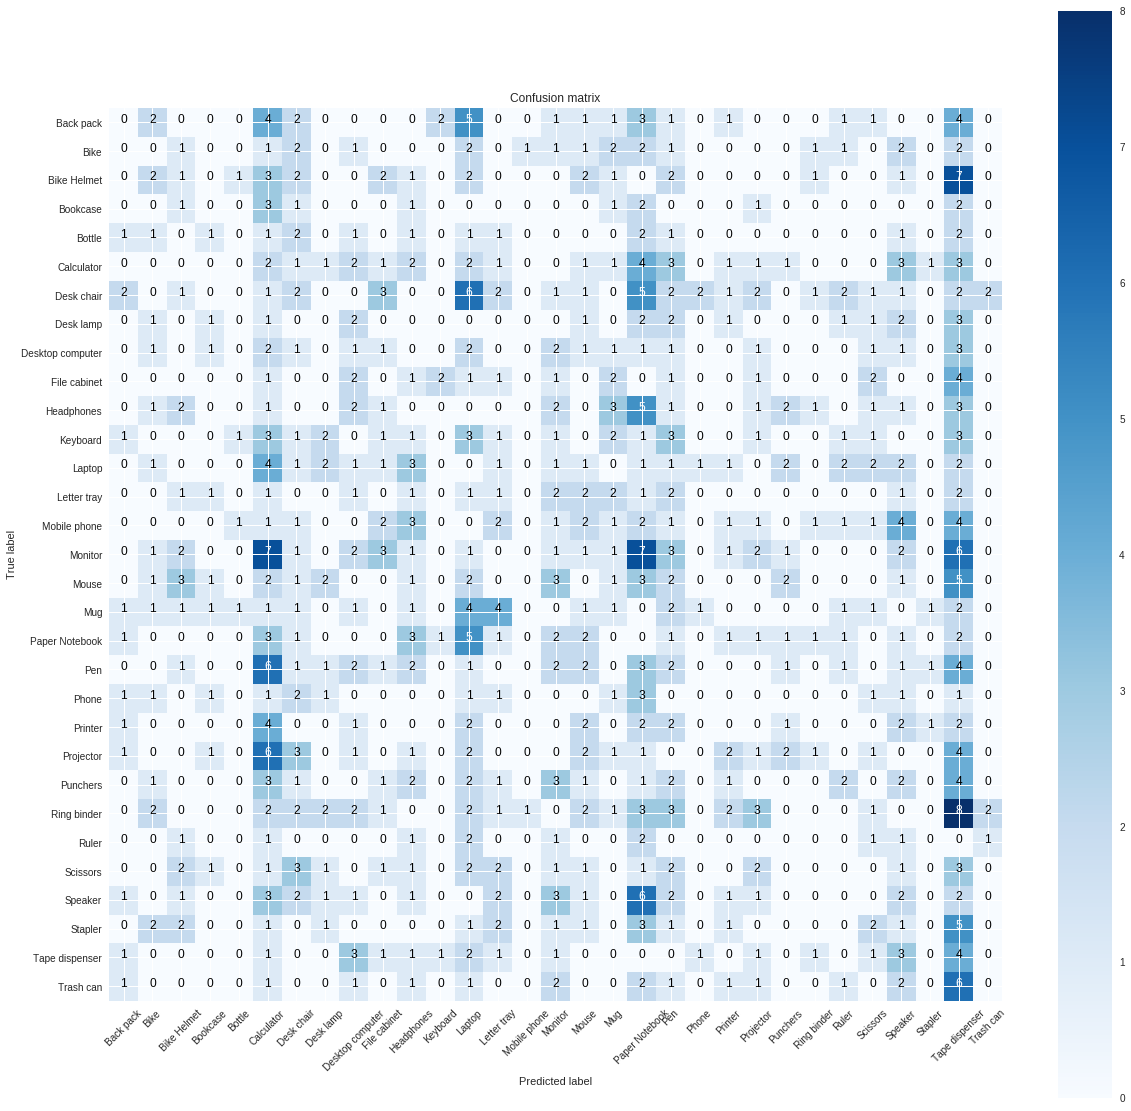

In [51]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [52]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

       Back pack       0.00      0.00      0.00        29
            Bike       0.00      0.00      0.00        21
     Bike Helmet       0.05      0.04      0.04        28
        Bookcase       0.00      0.00      0.00        12
          Bottle       0.00      0.00      0.00        16
      Calculator       0.03      0.06      0.04        31
      Desk chair       0.06      0.05      0.05        40
       Desk lamp       0.00      0.00      0.00        18
Desktop computer       0.04      0.05      0.04        21
    File cabinet       0.00      0.00      0.00        19
      Headphones       0.00      0.00      0.00        27
        Keyboard       0.00      0.00      0.00        27
          Laptop       0.00      0.00      0.00        30
     Letter tray       0.04      0.05      0.05        19
    Mobile phone       0.00      0.00      0.00        30
         Monitor       0.03      0.02      0.03  

In [0]:
model.save('inceptionV3.h5')

In [0]:
files.download('inceptionV3.h5')

In [0]:
files.download('checkpoint_DA.h5')